### Laboratorio 3: Clasificación Multiclase

#### Importamos las librerías necesarias:

In [33]:
import pandas as pd
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

#### Cargamos los datos:
No realicé un preprocesamiento de los datos porque ya estaban procesados además ya estaban separados en dos csv, uno para el entrenamiento y uno para las pruebas.

In [34]:
#Cargar Datos
data_train = pd.read_csv('../Laboratorio3/fashion-mnist_test.csv')
data_test = pd.read_csv('../Laboratorio3/fashion-mnist_test.csv')

Las imagenes ya estaban procesadas en un vector de 784 características (28x28 píxeles) 
y la primera columna es la etiqueta.

In [35]:
X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values
X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

#### Elección del método de normalización

No uso la función `featureNormalize` debido a que todas mis características (píxeles) tienen la misma escala (intensidad de luz) en el rango de [0,255], entonces considero que simplemente dividir por 255 es un enfoque más efectivo

In [36]:
# Normalizar las características
X_train = X_train / 255.0
X_test = X_test / 255.0

In [37]:
# Agregar el término de intercepción
X_train = np.concatenate([np.ones((X_train.shape[0], 1)), X_train], axis=1)
X_test = np.concatenate([np.ones((X_test.shape[0], 1)), X_test], axis=1)

In [38]:
# Regresión Logística One-vs-All
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

#### Visualización de los datos

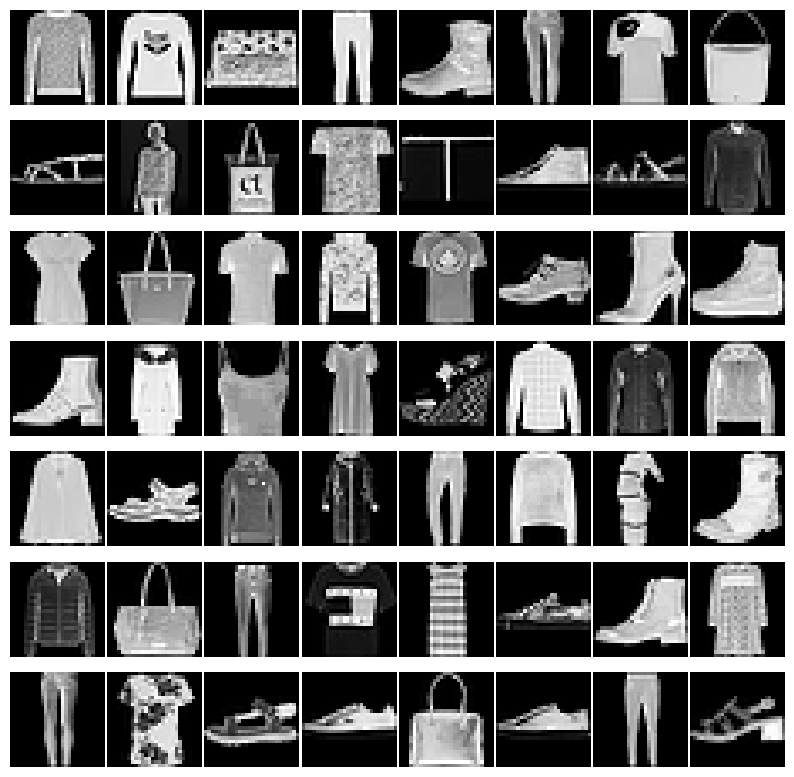

In [39]:
X = X_train[:, 1:]  # Excluimos la primera columna

def displayData(X, example_width=None, figsize=(10, 10)):
    """
    Muestra datos 2D almacenados en X en una cuadrícula apropiada.
    """
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]  # Promocionar a una matriz bidimensional
    else:
        raise IndexError('La entrada X debe ser 1 o 2 dimensional.')

    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = n / example_width

    # Calcula el número de elementos a mostrar
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil(m / display_rows))

    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace=0.025, hspace=0.025)

    ax_array = [ax_array] if m == 1 else ax_array.ravel()

    for i, ax in enumerate(ax_array):
        if i < m:
            # Asegúrate de mostrar solo los índices válidos
            ax.imshow(X[i].reshape(example_width, example_width), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')  # Oculta los ejes vacíos

# Selecciona aleatoriamente 50 puntos de datos para mostrar, asegurándote de que `X` solo contiene datos de píxeles
rand_indices = np.random.choice(X.shape[0], 56, replace=False)
sel = X[rand_indices, :]

# Muestra los datos
displayData(sel)


In [40]:
def lrCostFunction(theta, X, y, lambda_):
    m = y.size
    h = sigmoid(X.dot(theta))
    J = -1/m * (y.T.dot(np.log(h)) + (1-y).T.dot(np.log(1-h))) + lambda_/(2*m) * np.sum(np.square(theta[1:]))
    grad = 1/m * X.T.dot(h-y) + (lambda_/m) * np.hstack([0, theta[1:]])
    return J, grad

#### Visualización

In [52]:
from sklearn.model_selection import train_test_split

def plot_learning_curves(X_train, y_train, X_test, y_test, num_labels, lambda_=0.0):
    train_sizes = np.linspace(100, X_train.shape[0] * 0.99, 10, dtype=int)  # Ajusta los tamaños de entrenamiento
    train_errors, test_errors = [], []

    for m in train_sizes:
        # Si m es muy cercano al tamaño total, ajusta train_size para que sea una fracción.
        if m == X_train.shape[0]:
            train_size_frac = m / X_train.shape[0]  # Alternativamente, usa un valor fijo como 0.99
        else:
            train_size_frac = m
        
        X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=train_size_frac, random_state=42)
        all_theta = oneVsAll(X_train_subset, y_train_subset, num_labels, lambda_)
        y_train_pred = predictOneVsAll(all_theta, X_train_subset)
        y_test_pred = predictOneVsAll(all_theta, X_test)

        # Calcula la precisión
        train_accuracy = np.mean(y_train_pred == y_train_subset) * 100
        test_accuracy = np.mean(y_test_pred == y_test) * 100

        train_errors.append(100 - train_accuracy)
        test_errors.append(100 - test_accuracy)

    plt.plot(train_sizes, train_errors, label='Error de entrenamiento')
    plt.plot(train_sizes, test_errors, label='Error de validación')
    plt.title(f'Curvas de Aprendizaje (lambda = {lambda_})')
    plt.xlabel('Tamaño del conjunto de entrenamiento')
    plt.ylabel('Error (100 - Precisión)')
    plt.legend()
    plt.show()

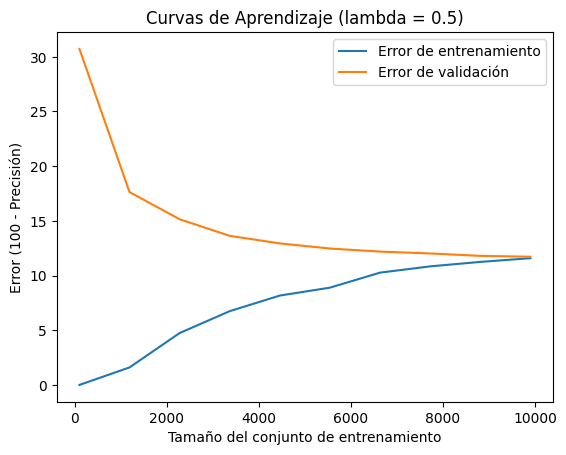

In [55]:
plot_learning_curves(X_train, y_train, X_test, y_test, num_labels, lambda_=0.5) 

#### Clasificación One-vs-All


In [42]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))
    
    for c in range(num_labels):
        initial_theta = np.zeros(n)
        options = {'maxiter': 50}
        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                (X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                options=options)
        all_theta[c] = res.x
    return all_theta

In [43]:
# Entrenamiento del Modelo
num_labels = 10  # Número de etiquetas/clases en el conjunto de datos Fashion-MNIST
lambda_ = 0.1    
all_theta = oneVsAll(X_train, y_train, num_labels, lambda_)

In [44]:
# Predicción
def predictOneVsAll(all_theta, X):
    m = X.shape[0]
    p = np.argmax(sigmoid(X.dot(all_theta.T)), axis=1)
    return p

In [47]:
# Evaluación
y_pred = predictOneVsAll(all_theta, X_test)
accuracy = np.mean(y_pred == y_test) * 100
print(f'Precisión en el conjunto de prueba: {accuracy:.2f}%')

Precisión en el conjunto de prueba: 88.32%


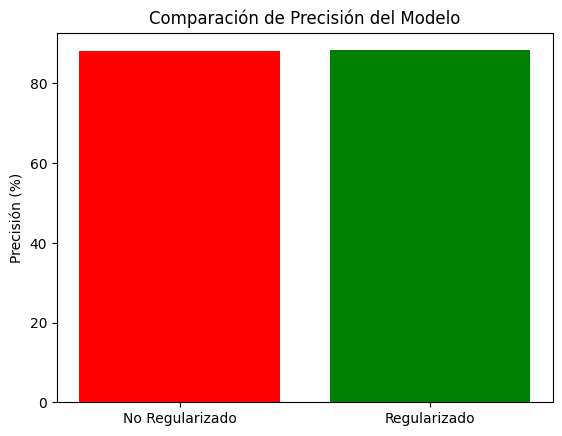

In [49]:
import matplotlib.pyplot as plt

accuracy_regularized = 88.32  
accuracy_non_regularized = 88.23  

# Etiquetas para las barras
labels = ['No Regularizado', 'Regularizado']

# Valores de precisión para cada barra
accuracies = [accuracy_non_regularized, accuracy_regularized]

# Creando la gráfica de barras
plt.bar(labels, accuracies, color=['red', 'green'])

plt.title('Comparación de Precisión del Modelo')
plt.ylabel('Precisión (%)')

# Mostrando la gráfica
plt.show()